# Stock Prices

_In physics it takes three laws to explain 99% of the data; in finance it takes more than 99 laws to explain about 3%_ - Andrew Lo 

Stock price data encompasses historical prices as well as corporate actions such as stock splits, dividends, and delistings. The CRSP database is a standard resource in academic research due to its comprehensive coverage of both active and delisted stocks, which supports unbiased and representative analysis. Efficient storage, retrieval, and processing of such structured financial data are enabled by tools such as SQL, SQLAlchemy, Redis, and Pandas. We examine statistical moments, assume log-normal distributions, and explore alternative correlation measures for modeling stock return behavior and dependencies.





In [4]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import scipy
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, CRSPBuffer, Benchmarks
from finds.utils import Finder
from secret import credentials, CRSP_DATE, paths
VERBOSE = 0

# %matplotlib qt

## FinDS package

Developed over a journey to support financial data science workflows, our [_FinDS_ Python package](https://github.com/terence-lim/financial-data-science) integrates:

- Use of database engines like SQL, Redis, and MongoDB to manage large structured and unstructured datasets  
- Tools for accessing key financial datasets, including CRSP, Compustat, IBES, and TAQ  
- Interfaces to public data sources such as FRED, SEC EDGAR, and the BEA  
- Utilities for extracting data from academic and research websites  
- Recipes for applying a range of statistical and machine learning methods, including network graphs, natural language processing and large language models.

### SQL

**Structured Query Language (SQL)** is a popular tool for storing and managing relational data organized into tables with columns (fields) and rows (records). Open-source systems like **MySQL** are widely used to implement relational databases, and Python libraries such as **SQLAlchemy** provide convenient interfaces for interacting with them. Additionally, the **Pandas** library allows users to run SQL queries and load the results directly into DataFrames for efficient analysis.

### Redis

**Redis** is an open-source, in-memory data store commonly used as a caching layer. It helps improve performance by storing frequently accessed data in memory, thereby reducing the load on slower, primary databases.

In [2]:
# open database connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, endweek=3, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
find = Finder(sql)
outdir = paths['scratch']

## Stock price data

Besides the historical prices of stocks, their adjustments such as identifier changes, stock splits, dividends, mergers, and delistings must also be recorded to accurately analyze performance over time.


### CRSP stocks

The Center for Research in Security Prices (CRSP) provides the most widely used data for academic research into US stocks. It includes both successful and unsuccessful entities, rather than just those that have "survived" over time. This helps avoid the pitfalls of focusing only on surviving entities which can lead to an overestimation of average performance and underestimation of risk. It also captures corporate actions by standardizing data on events such as name changes, distributions and delistings. This information is recorded and validated from official sources, integrated into its historical databases along with details like announcement and effective dates, adjustment factors, and impact on stock performance calculations.

In [3]:
# describe the database schema of the CRP Stocks `names` table 
DataFrame(**sql.run('describe names'))

,Field,Type,Null,Key,Default,Extra
0,date,int,NO,PRI,None,
1,comnam,varchar(32),YES,,None,
2,ncusip,varchar(8),YES,MUL,None,
3,shrcls,varchar(1),YES,,None,
4,ticker,varchar(5),YES,,None,
5,permno,int,NO,PRI,None,
6,nameendt,int,YES,,None,
7,shrcd,smallint,YES,,None,
8,exchcd,smallint,YES,,None,
9,siccd,smallint,YES,,None,


SQL `select` and `join` statements to retrieve Apple Computer's identifiers and corporate actions, such as stock splits and dividends. Commonly used SQL commands listed at the end of this notebook.

In [4]:
# double up the % when passing sql command stringo to pandas
names_df = pd.read_sql("select * from names where comnam like '%%APPLE COMPUTER%%'", con=sql.engine)
names_df

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19801212,APPLE COMPUTER INC,03783310,,AAPL,14593,19821031,11,3,3573,,0,Q,A,R,7
1,19821101,APPLE COMPUTER INC,03783310,,AAPL,14593,20040609,11,3,3573,AAPL,0,Q,A,R,7
2,20040610,APPLE COMPUTER INC,03783310,,AAPL,14593,20070110,11,3,3573,AAPL,334111,Q,A,R,7


In [5]:
# inner join of identifiers (names) and distributions (dist) tables
cmd = """
select distinct names.permno, divamt, facpr, exdt, comnam, ticker from names 
inner join dist
on names.permno = dist.permno
where names.comnam like '%%APPLE COMPUTER%%'
"""
dist_df = pd.read_sql(cmd, con=sql.engine)
dist_df

,permno,divamt,facpr,exdt,comnam,ticker
0,14593,0.12,0.0,19870511,APPLE COMPUTER INC,AAPL
1,14593,0.06,0.0,19870810,APPLE COMPUTER INC,AAPL
2,14593,0.08,0.0,19871117,APPLE COMPUTER INC,AAPL
3,14593,0.08,0.0,19880212,APPLE COMPUTER INC,AAPL
4,14593,0.08,0.0,19880516,APPLE COMPUTER INC,AAPL
...,...,...,...,...,...,...
86,14593,0.00,1.0,19870616,APPLE COMPUTER INC,AAPL
87,14593,0.00,1.0,20000621,APPLE COMPUTER INC,AAPL
88,14593,0.00,1.0,20050228,APPLE COMPUTER INC,AAPL
89,14593,0.00,6.0,20140609,APPLE COMPUTER INC,AAPL


### Stock splits and dividends

An investor's total holding returns (`ret` in CRSP) include gains from appreciated stock prices (`prc`), adjusted for stock splits (`facpr`), plus ordinary cash dividends (`divamt`). Specifically, on ex-dates $t$:

$$ret_t = \dfrac{prc_t \ (1 + facpr_t) + div_t}{prc_{t-1}}$$


The Factor to Adjust Price (`facpr`) values over time can be used to adjust prices for distributions such as stock dividends and splits so that stock prices before and after one or more distributions are comparable.  Historical cumulative adjust factors are computed by additing 1 to and then taking cumulative product from current to earlier time periods. This cumulative factor between two dates is divided into the earlier raw stock price to derive comparable split-adjusted prices. Hence to split-adjust CRSP raw prices
- apply cumulative factor to raw prices before corresponding ex-date
- back-fill to dates prior to ex-date
- default factor after latest ex-date is 1

__yfinance__

The yfinance Python library enables users to access current financial data from Yahoo Finance. 

In [6]:
import yfinance as yf
ticker = yf.Ticker('AAPL')
df = ticker.history(period='max')
df[df['Dividends'].gt(0) | df['Stock Splits'].ne(0)]


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1987-05-11 00:00:00-04:00,0.264817,0.273415,0.263957,0.264817,197276800,0.000536,0.0
1987-06-16 00:00:00-04:00,0.285452,0.287171,0.261378,0.285452,342720000,0.000000,2.0
1987-08-10 00:00:00-04:00,0.332310,0.332310,0.315091,0.332310,77996800,0.000536,0.0
1987-11-17 00:00:00-05:00,0.253658,0.255384,0.241579,0.241579,268800000,0.000714,0.0
1988-02-12 00:00:00-05:00,0.280957,0.287009,0.280093,0.283551,137760000,0.000714,0.0
...,...,...,...,...,...,...,...
2024-02-09 00:00:00-05:00,187.763406,189.097120,187.116467,187.962479,45155200,0.240000,0.0
2024-05-10 00:00:00-04:00,184.280653,184.470019,181.519943,182.436859,50759500,0.250000,0.0
2024-08-12 00:00:00-04:00,215.595507,219.027939,215.126538,217.052292,38028100,0.250000,0.0


The daily `Close` prices from yFinance have been adjusted for stock splits and dividend payments. As a result, the plotted values directly represent cumulative total holding returns.

<Axes: title={'center': 'APPL close prices from yfinance'}, xlabel='Date'>

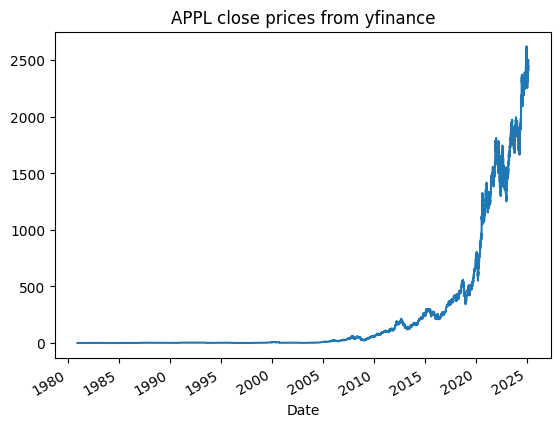

In [7]:
df['Close'].div(df['Close'].iloc[0]).plot(title="APPL close prices from yfinance")

To retrieve unadjusted historical prices accounting for stock splits and dividends, first apply the split factors to determine the original dividends per unadjusted share. The resulting values closely match the CRSP `divamt` figures, with minor differences likely due to cumulative numerical precision errors.

In [8]:
split = df['Stock Splits'].where(df['Stock Splits'] != 0.0, 1)\
    .shift(-1).fillna(1).iloc[::-1].cumprod().iloc[::-1]       # cumulate the split factors back in time
df['unadj_div'] = df['Dividends'] * split.shift(1).fillna(split.iloc[0])   # apply the split factors to dividends
df.set_index(df.index.strftime('%Y-%m-%d'))[(df['unadj_div'] > 0).values]


,Open,High,Low,Close,Volume,Dividends,Stock Splits,unadj_div
Date,,,,,,,,
1987-05-11,0.264817,0.273415,0.263957,0.264817,197276800,0.000536,0.0,0.120064
1987-08-10,0.332310,0.332310,0.315091,0.332310,77996800,0.000536,0.0,0.060032
1987-11-17,0.253658,0.255384,0.241579,0.241579,268800000,0.000714,0.0,0.079968
1988-02-12,0.280957,0.287009,0.280093,0.283551,137760000,0.000714,0.0,0.079968
1988-05-16,0.280647,0.286711,0.277183,0.285845,74760000,0.000714,0.0,0.079968
...,...,...,...,...,...,...,...,...
2024-02-09,187.763406,189.097120,187.116467,187.962479,45155200,0.240000,0.0,0.240000
2024-05-10,184.280653,184.470019,181.519943,182.436859,50759500,0.250000,0.0,0.250000
2024-08-12,215.595507,219.027939,215.126538,217.052292,38028100,0.250000,0.0,0.250000


Next, we work backward through time to reconstruct the original stock prices using daily holding returns and closing prices. Stock splits and dividends are accounted for on ex-dates by applying the rearranged formula:

$$prc_{t-1} = \dfrac{(1+facpr_t) (prc_t + div_t)}{ret_t}$$

In [9]:
rets = df['Close'] / df['Close'].shift(1)
prc = df['Close'].iloc[-1]
div = 0
fac = 0
ret = 1
for i, t in enumerate(df.index[::-1]):     # iterate over days in reverse
    df.loc[t, 'unadj_prc'] =  (((fac if fac else 1) * prc) + div) / ret
    prc = df.loc[t, 'unadj_prc']
    div = df.loc[t, 'unadj_div']
    fac = df.loc[t, 'Stock Splits']
    ret = rets.loc[t]
df.set_index(df.index.strftime('%Y-%m-%d'))

,Open,High,Low,Close,Volume,Dividends,Stock Splits,unadj_div,unadj_prc
Date,,,,,,,,,
1980-12-12,0.098726,0.099155,0.098726,0.098726,469033600,0.0,0.0,0.0,28.757305
1980-12-15,0.094005,0.094005,0.093575,0.093575,175884800,0.0,0.0,0.0,27.257003
1980-12-16,0.087136,0.087136,0.086707,0.086707,105728000,0.0,0.0,0.0,25.256412
1980-12-17,0.088853,0.089282,0.088853,0.088853,86441600,0.0,0.0,0.0,25.881523
1980-12-18,0.091429,0.091858,0.091429,0.091429,73449600,0.0,0.0,0.0,26.631895
...,...,...,...,...,...,...,...,...,...
2025-02-24,244.929993,248.860001,244.419998,247.100006,51326400,0.0,0.0,0.0,247.100006
2025-02-25,248.000000,250.000000,244.910004,247.039993,48013300,0.0,0.0,0.0,247.039993
2025-02-26,244.330002,244.979996,239.130005,240.360001,44433600,0.0,0.0,0.0,240.360001


The unadjusted price computer and the original closing prices from CRSP during the early days of AAPL stock are nearly identical, with only small differences due to cumulative numerical precision errors.

In [10]:
price_df = pd.read_sql(f"select permno, date, abs(prc) from daily where permno={names_df['permno'][0]}", con=sql.engine)
price_df.head(10)

,permno,date,abs(prc)
0,14593,19801212,28.8125
1,14593,19801215,27.3125
2,14593,19801216,25.3125
3,14593,19801217,25.9375
4,14593,19801218,26.6875
5,14593,19801219,28.3125
6,14593,19801222,29.6875
7,14593,19801223,30.9375
8,14593,19801224,32.5625
9,14593,19801226,35.5625


### Market capitalization



Following Fama and French (1992), academic research typically focuses on U.S.-domiciled stocks, specifically those with a share code (`shrcd`) of 10 or 11, that are listed on major exchanges (exchange code (`exchcd`) of 1, 2, or 3).

Stocks are often sorted into ten deciles based on market capitalization, with the smallest stocks placed in the 10th decile. These decile breakpoints are determined using only NYSE-listed stocks. For companies with multiple classes of securities, total market value is calculated by summing the market capitalization of all classes. Since CRSP reports shares outstanding (shrout) in thousands, all market capitalization values must be multiplied by 1,000 to reflect their actual size.

Plot the number of stocks in and the market cap breakpoints of each size decile by year:

In [11]:
# retrieve universe of stocks annually from 1981
start = bd.endyr(19731231)
rebals = bd.date_range(start, CRSP_DATE, freq=12)
univs = {rebal: crsp.get_universe(date=rebal) for rebal in rebals}
num = dict()
for date, univ in univs.items():
    num[str(date//10000)] = {decile: sum(univ['decile']==decile)
                             for decile in range(10, 0, -1)}
num = DataFrame.from_dict(num, orient='index')

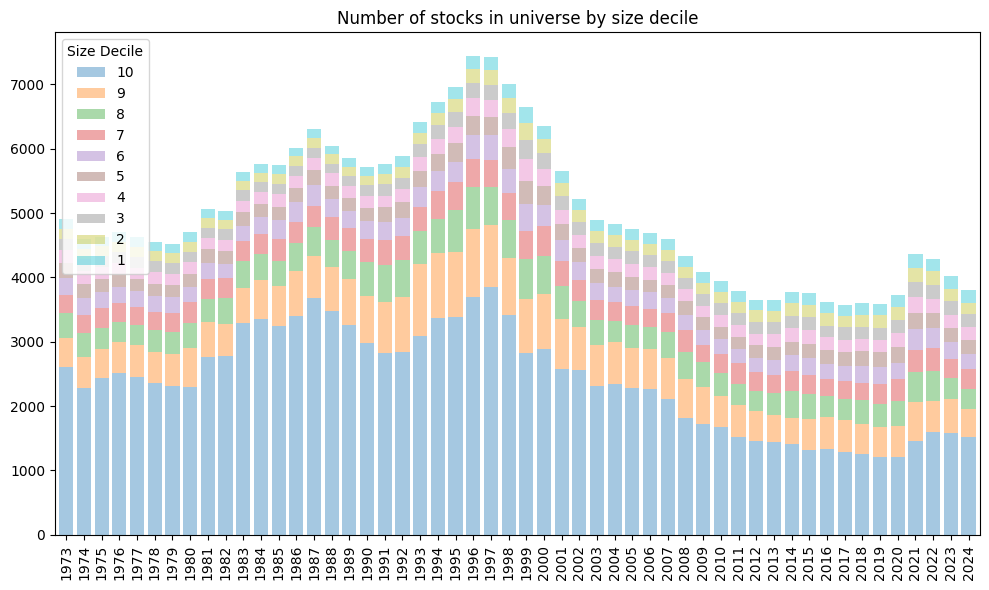

In [12]:
# plot number of stocks in each size decile
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Number of stocks in universe by size decile')
num.plot.bar(stacked=True, ax=ax, width=.8, alpha=0.4)
#set_xtickbins(ax=ax, nbins=len(cap)//10)
plt.legend(title='Size Decile', loc='upper left')
plt.tight_layout()

In [13]:
# If a company has multiple share classes, sum up its total market capitalization 
# instead of separate capital values for each share class
names = find('ALPHABET', 'comnam').groupby('permno').tail(1).set_index('permno')
names

,date,comnam,ncusip,shrcls,ticker,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
permno,,,,,,,,,,,,,,,
14542,20231013,ALPHABET INC,02079K10,C,GOOG,20241231,11,3,7375,GOOG,541511,Q,A,R,45483
90319,20231013,ALPHABET INC,02079K30,A,GOOGL,20241231,11,3,7375,GOOGL,541511,Q,A,R,45483


In [14]:
univ.loc[names.index]  # market caps of share class (cap) and total company (capco)

,cap,capco,decile,nyse,siccd,prc,naics
permno,,,,,,,
14542,1.053895e+09,2.159975e+09,1,False,7375,190.44,541511
90319,1.106080e+09,2.159975e+09,1,False,7375,189.30,541511


### Stock delistings

An important feature of the CRSP database is that it is free of survivorship-bias.  It includes the historical records of stocks that have delisted from trading on the exchanges.

In CRSP Monthly, the Delisting Return is calculated from the last
month ending price to the last daily trading price if no other
delisting information is available. In this case the delisting
payment date is the same as the delisting date.  If the return is
calculated from a daily price, it is a partial-month return. The
partial-month returns are not truly Delisting Returns since they do
not represent values after delisting, but allow the researcher to
make a more accurate estimate of the Delisting Returns.

Following Bali, Engle, and Murray (2016) and Shumway (1997): we can
construct returns adjusted for delistings, which result when a
company is acquired, ceases operations, or fails to meet exchange
listing requirements. The adjustment reflects the partial month of
returns to investors who bought the stock in the month before the
delisting. For certain delisting codes ([500, 520, 551..574, 580,
584]) where the delisting return is missing, a delisting return of -30%
is assumed which reflects the average recovery amount after delisting.

In [15]:
# Show sample of original CRSP Monthly ret and dlret before and after adjustment            
pd.read_sql('select * from monthly where dlstcd>100 and date=20041130', sql.engine)\
  .set_index('permno')\
  .rename(columns={'ret': 'original_ret'})\
  .join(crsp.get_ret(beg=20041101, end=20041130), how='left')\
  .round(4)

,date,prc,original_ret,retx,dlstcd,dlret,ret
permno,,,,,,,
10275,20041130,NaN,NaN,NaN,584,-0.2703,-0.2703
10418,20041130,NaN,NaN,NaN,520,0.0509,0.0509
11194,20041130,NaN,NaN,NaN,233,0.0066,0.0066
12010,20041130,NaN,NaN,NaN,587,0.0490,0.0490
20459,20041130,NaN,NaN,NaN,231,0.0724,0.0724
32897,20041130,NaN,NaN,NaN,584,-0.2357,-0.2357
55589,20041130,NaN,NaN,NaN,233,-0.0114,-0.0114
64290,20041130,13.70,0.0178,0.0178,233,0.0000,0.0178
67708,20041130,NaN,NaN,NaN,233,0.0164,0.0164


## Properties of stock returns

### Long-run market averages

Calculate and plot the time series of annual cross-sectional averages of stock returns, where each year's average is cap-weighted, and the final time series is equal-weighted.

Over time, the contribution of dividend yield to total average stock returns has decreased, while share trading turnover has increased.


In [31]:
# Loop over the 20-year eras, and compute means of annual cap-weighted averages
years = range(1925, 2025, 20)
results = DataFrame(columns=['divyld', 'turnover', 'means'])
for era in tqdm(years):
    label = f"{era+1}-{era+20}"
    divyld, means, turnover = {}, {}, {}

    for year in bd.date_range(era, min(CRSP_DATE//10000 -1 , era+19), freq=12):
        # universe stocks at end of year
        univ = crsp.get_universe(bd.endyr(year))

        # retrieve cap-weighted average of next year's returns
        cmd = f"""
select permno, SUM(LOG(1+ret)) AS ret FROM daily
WHERE date > {bd.endyr(year)} AND date <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        means[year] = (np.exp(df['ret'])-1).dot(df['cap']) / df['cap'].sum()

        # retrieve cap-weighted average of annualized turnover
        cmd = f"""
select permno, 252*AVG(vol/(shrout*1000)) AS turnover FROM daily
WHERE date > {bd.endyr(year)} AND date <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        turnover[year] = df['turnover'].dot(df['cap']) / df['cap'].sum()

        # retrieve cap-weighted average of annual dividend amounts
        cmd = f"""
SELECT dist.permno as permno, SUM(daily.shrout * dist.divamt) AS divamt
FROM dist INNER JOIN daily
ON daily.permno = dist.permno AND daily.date = dist.exdt
WHERE dist.divamt > 0 AND dist.exdt > {bd.endyr(year)} 
  AND dist.exdt <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        divyld[year] = df['divamt'].sum() / df['cap'].sum()

    results.loc[label, 'turnover'] = np.mean(list(turnover.values()))
    results.loc[label, 'divyld'] = np.mean(list(divyld.values()))
    results.loc[label, 'means'] = np.mean(list(means.values()))

100%|██████████| 5/5 [1:03:37<00:00, 763.46s/it]


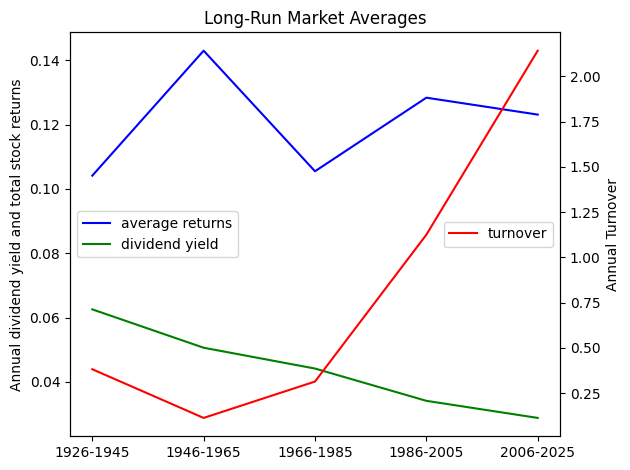

In [32]:
# Plot mean returns, dividend yield and turnover using both y-axes
fig, ax = plt.subplots()
ax.plot(results['means'], color="blue")
ax.plot(results['divyld'], color="green")
ax.legend(['average returns', 'dividend yield'], loc="center left")
ax.set_ylabel("Annual dividend yield and total stock returns")
bx = ax.twinx()
bx.plot(results['turnover'], color="red")
bx.set_ylabel("Annual Turnover")
bx.legend(['turnover'], loc="center right")
plt.title("Long-Run Market Averages")
plt.tight_layout()



### Statistical moments

The volatility of an asset is usually measured using the standard deviation of the returns. The common practice is to report the annualized volatility using the square-root rule which assumes that variance scales linearly with time: e.g. daily by $\sqrt{252}$, weekly by $\sqrt{52}$, monthly by $\sqrt{12}$.  Mean returns are annualized by multiplying by the respective number of periods in a year.  

A normal distribution is symmetric and thin-tailed, and so has no skewness or excess kurtosis. However, many return series are both skewed and fat-tailed (kurtosis in excess of 3).  A left-skewed distribution is longer on the left side of its peak than on its right. In other words, a left-skewed distribution has a long tail on its left side, where the mean typically lies to the left of its median. Left skew is also referred to as negative skew. Right or positive skew has the opposite properties.

Stock prices are often modeled with a log-normal distribution because prices cannot be negative. Large positive jumps are possible, but extreme negative moves are bounded at zero, hence the distribution of log-normal returns is positively-skewed with a long right tail. The skewness of a log-normal distribution is given by:  $(e^{\sigma^2} + 2) \sqrt{e^{\sigma^2} - 1}$  

By Jensen's inequality, the arithmetic mean is greater than the geometric mean. Under the assumption of log-normality, the amount by which the arithmetic mean exceeds the geometric means of returns is half the volatility.

- Suppose the continuously compounded (log) returns \( r_t \) are normally distributed with mean \( \mu \) and variance \( \sigma^2 \): $r_t = \ln \left(\frac{P_t}{P_{t-1}}\right) \sim N(\mu, \sigma^2)$
- The geometric mean return is given by $\mu_G = \frac{1}{T} \sum_{t=1}^{T} r_t$, with expectation $\mathbb{E}[r_t] = \mu$

- The arithmetic mean of the simple returns is approximately given by $\mu_A \approx e^{\mu + \frac{1}{2} \sigma^2} - 1 \approx \mu_G + \frac{1}{2} \sigma^2$, using the first-order approximation $e^x \approx 1 + x$ for small $x$.

__Jarque-Bera test__

The Jarque-Bera test statistic can be used to test whether the sample skewness and kurtosis are compatible with an assumption that the returns are normally distributed. When returns are normally distributed, the skewness is asymptotically normally distributed with a variance of 6, so (skewness)$^2/6$ has a $\chi^2_1$
distribution. Meanwhile, the kurtosis is asymptotically normally distributed with mean 3 and variance of 24, and so (kurtosis - 3)$^2/24$ also has a $\chi^2_1$
distribution. These two statistics are 
asymptotically independent (uncorrelated), and so their sum is $~\chi^2_2$


In [5]:
# Compute the stock returns sampled at various frequencies
intervals = {'annual': (12, 1), 'monthly': ('e', 12), 'weekly': ('w', 52), 'daily': ('d', 252)}
moments = []
begdate, enddate = bd.begyr(CRSP_DATE//10000 - 19), bd.endyr(CRSP_DATE//10000)

for dataset, (freq, annualize) in intervals.items():

    # If annual or monthly frequency, use StocksBuffer to pre-load all monthly returns
    if dataset not in ['daily', 'weekly']:
        stocks = CRSPBuffer(stocks=crsp, dataset='monthly', fields=['ret'],
                            beg=bd.begyr(begdate), end=enddate)
    if dataset in ['weekly']:  # weekly returns already computed from CRSP Daily, and cached
        stocks = crsp

    univ_year = bd.endyr(begdate - 1)  # universe as of end of previous calendar year               
    dates = bd.date_range(bd.endyr(begdate), bd.endyr(enddate), freq=freq)
    allstocks = []
    for beg, end in tqdm(bd.date_tuples(dates)):

        # Update the investment universe every calendar year                                        
        if bd.endyr(beg) != univ_year:
            univ = crsp.get_universe(univ_year)
            univ_year = bd.endyr(beg)

            # Use StocksBuffer to cache daily returns for the new calendar year                     
            if dataset in ['daily']:
                stocks = CRSPBuffer(stocks=crsp, dataset='daily', fields=['ret'],
                                    beg=bd.offset(beg, -1), end=bd.endyr(end))

        # retrieve returns for universe stocks                                                      
        ret = stocks.get_ret(beg=beg, end=end).reindex(univ.index)
        allstocks.append(ret.rename(end))

    # combine all years' stock returns, require stock in all years                                  
    allstocks = pd.concat(allstocks, axis=1, join='inner')

    # compute annualized moments, ignoring small sample warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        out = {
            f"MeanAnnualized": np.nanmedian(
                np.nanmean(np.log(1 + allstocks), axis=1)) * annualize,
            f"VolAnnualized": np.nanmedian(
                np.nanstd(allstocks, axis=1, ddof=0)) * np.sqrt(annualize),
            f"Skewness": np.nanmedian(
                scipy.stats.skew(allstocks, nan_policy='omit', axis=1)),
            f"ExcessKurtosis": np.nanmedian(
                scipy.stats.kurtosis(allstocks, nan_policy='omit', axis=1)),
            f"Count": len(allstocks),
        }
    df = DataFrame({dataset: Series(out)}).T
    moments.append(df)
moments = pd.concat(moments, axis=0)  # accumulate df to results                                    
moments.reset_index().to_json(outdir / 'moments.json')


100%|██████████| 4781/4781 [07:05<00:00, 11.23it/s] 


As we move from annual to daily sampling, stock returns exhibit greater kurtosis (i.e. fat tails) and annualized standard deviation. Skewness is positive -- the right tail of the distribution is longer than the left tail -- but are U-shaped with daily and annual returns featuring more positive-skewness than weekly or monthly.

In [7]:
moments

,MeanAnnualized,VolAnnualized,Skewness,ExcessKurtosis,Count
annual,0.063249,0.356397,0.434219,0.002332,1519.0
monthly,0.063249,0.376568,0.314758,2.242009,1519.0
weekly,0.062119,0.402871,0.293850,6.612277,1519.0
daily,0.063325,0.429472,0.404691,13.332600,1519.0


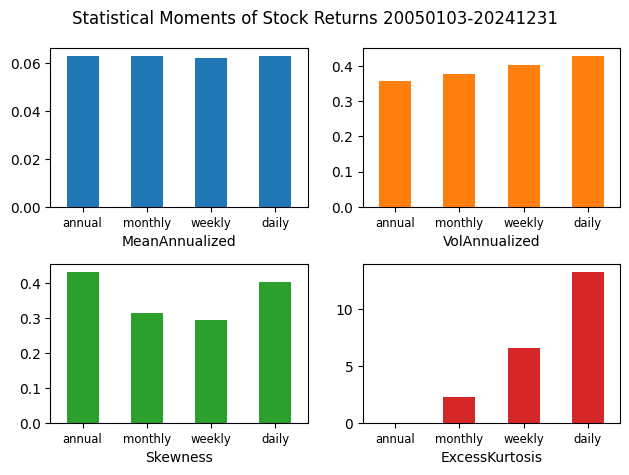

In [6]:
fig, axes = plt.subplots(2,2)
for ix, ax in enumerate(axes.flatten()):
    moments[moments.columns[ix]].plot.bar(ax=ax, color=f"C{ix}")
    ax.set_xticklabels(moments.index, rotation=0, fontsize='small')
    ax.set_xlabel(moments.columns[ix])
plt.suptitle(f"Statistical Moments of Stock Returns {begdate}-{enddate}")
plt.tight_layout()
plt.show()

### Correlations  

**Pearson’s correlation**, also known as the linear correlation estimator, measures the strength of a linear relationship between two variables. However, alternative methods can better capture nonlinear dependencies:  

- **Spearman's rank correlation** applies Pearson’s correlation to the ranked values of observations, measuring monotonic relationships while being less sensitive to outliers.  
- **Kendall’s $\tau$** quantifies the relationship between two variables by comparing the number of concordant and discordant pairs -- pairs that agree or disagree on ordering. It is robust to outliers and effective for skewed or non-normally distributed data.  

Monthly SP500 and 30-year Treasury total market returns show positive correlation, which is fairly robust across the three methods.
 

In [37]:
# retrieve SP500 and 30-Year Treasury total market returns from CRSP Indexes
ret = bench.get_series(['sprtrn', 'b30ret(mo)'], field='ret').dropna()
ret


permno,sprtrn,b30ret(mo)
date,,
19620731,0.006917,-0.008187
19620831,0.007498,0.031939
19620928,0.008965,0.015465
19621031,-0.000354,0.012171
19621130,-0.002403,0.003414
...,...,...
20240830,0.010093,0.020778
20240930,0.004237,0.015521
20241031,-0.018615,-0.053895


In [38]:
# Compute alternative measures of correlation
DataFrame(dict(spearman=scipy.stats.spearmanr(ret['sprtrn'], ret['b30ret(mo)'])[0],
               kendall=scipy.stats.kendalltau(ret['sprtrn'], ret['b30ret(mo)'])[0],
               pearson=scipy.stats.pearsonr(ret['sprtrn'], ret['b30ret(mo)'])[0]),
               index=['Correlation of SP500 vs 30-Year Treasury Total Returns']).round(4)

,spearman,kendall,pearson
Correlation of SP500 vs 30-Year Treasury Total Returns,0.1348,0.0933,0.1275


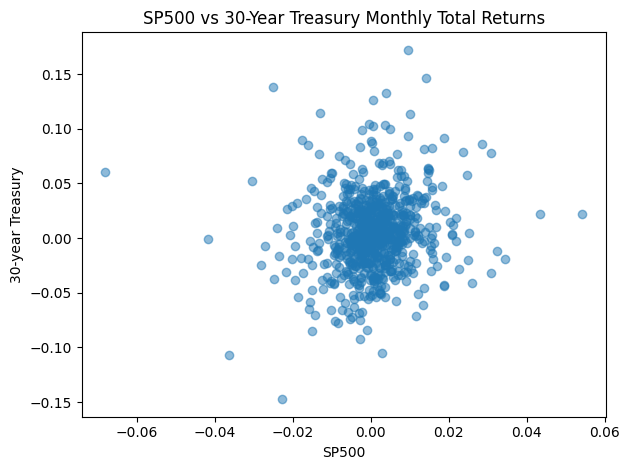

In [40]:
# Scatter plot of SP500 and and 30-year Treasury total market returns
fig, ax = plt.subplots()
ax.scatter(ret['sprtrn'], ret['b30ret(mo)'], alpha=0.5)
ax.set_xlabel('SP500')
ax.set_ylabel('30-year Treasury')
plt.title('SP500 vs 30-Year Treasury Monthly Total Returns')
plt.tight_layout()            

__APPENDIX__




_SQL commands_

- Manage tables

  - CREATE DATABASE -- Creates a new database.

  - CREATE TABLE -- Creates a new table. 

  - DELETE -- Delete data from a table.

  - DROP COLUMN -- Deletes a column from a table.

  - DROP DATABASE -- Deletes the entire database.

  - DROP TABLE -- Deletes a table from a database.

  - TRUNCATE TABLE -- Deletes the data but does not delete the table.



- __Querying a table__

  - SELECT -- Used to select data from a database, which is then returned in a results set.

  - SELECT DISTINCT -- Sames as SELECT, except duplicate values are excluded.

  - SELECT INTO -- Copies data from one table and inserts it into another.

  - UNIQUE -- This constraint ensures all values in a column are unique.

  - FROM -- Specifies which table to select or delete data from.

  - AS -- Renames a table or column with an alias value which only exists for the duration of the query.

- __Query conditions__

  - WHERE -- Filters results to only include data which meets the given condition.

  - AND -- Used to join separate conditions within a WHERE clause.

  - BETWEEN -- Selects values within the given range.

  - IS NULL -- Tests for empty (NULL) values.

  - IS NOT NULL -- The reverse of NULL. Tests for values that aren’t empty / NULL.

  - LIKE -- Returns true if the operand value matches a pattern.

  - NOT -- Returns true if a record DOESN’T meet the condition.
 
  - OR -- Used alongside WHERE to include data when either condition is true.

- __Organize results__

  - ORDER BY -- Used to sort the result data in ascending (default) or descending order through the use of ASC or DESC keywords.

  - GROUP BY -- Used alongside aggregate functions (COUNT, MAX, MIN, SUM, AVG) to group the results.

- __Join tables__

  - INNER JOIN returns rows that have matching values in both tables.

  - LEFT JOIN returns all rows from the left table, and the matching rows from the right table.- 

  - RIGHT JOIN returns all rows from the right table, and the matching records from the left table

  - FULL OUTER JOIN returns all rows when there is a match in either left table or right table.

__References:__

Fama, Eugene F., and Kenneth R. French. 1992. “The cross-section of expected stock returns.” The Journal of Finance 47 (2): 427–65.

Shumway, Tyler. 1997. The Delisting Bias in CRSP Data. The Journal of Finance, 52, 327-340. 

Bali, Turan G, Robert F Engle, and Scott Murray. 2016. Empirical asset pricing: The cross section of stock returns. John Wiley & Sons.

Stulz, René M., 2018, "The Shrinking Universe of Public Firms: Facts, Causes, and Consequences", National Bureau of Economics, 2 (June 2018)

FRM Exam Book Part I Quantative Analysis Chapter 12

Wharton Research Data Services.